In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datadata import utils
from prevision import *
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display

In [9]:
input_sequence_length=14
output_sequence_length=7
SCORING=1 # 0 for MSE, 1 for MAE
EVAL_METRIC=1
scoring_RCV = {0:'neg_mean_squared_error',1:'neg_mean_absolute_error'}[SCORING]
scoring_Ray={0:'rmse',1:'mae'}[SCORING]
eval_metric={0:'rmse',1:'mae'}[SCORING]
df_all,x,y=getAllDataFromCSV()

In [3]:
class WindowGenerator():
    def __init__(self, X, Y, input_sequence_length=14, output_sequence_length=7):
        self.X=X
        self.Y=Y
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        
        assert (len(self.X) - self.input_sequence_length - self.output_sequence_length + 1 > 0), \
            f'Dataset size too small for current options\ndata:{len(self.X)}, ' \
            f'input_sequence_length:{input_sequence_length}, output_sequence_length:{output_sequence_length}'

    def __len__(self):  # number of windows we can generate to work it must be at least 1
        return len(self.X) - self.input_sequence_length - self.output_sequence_length + 1

    def __getitem__(self, idx):
        x=np.concatenate(
            (self.X[idx:idx + self.input_sequence_length], self.Y[idx:idx + self.input_sequence_length][:, None]),1)
        y = self.Y[
            idx + self.input_sequence_length:idx + self.input_sequence_length + self.output_sequence_length]
        return x, y

def split_data_based_on_duration(data, duration_months):
    last_date = data['date'].max()
    cutoff_date = last_date - pd.DateOffset(months=duration_months)
    train_data = data[data['date'] <= cutoff_date]
    validation_data = data[data['date'] > cutoff_date]
    return train_data, validation_data

def getXY(data,input_sequence_length=14, output_sequence_length=7):
    x=data.drop(['date','vente'],axis=1).values
    y=data['vente'].values
    win=WindowGenerator(x,y,input_sequence_length, output_sequence_length)
    newX=[]
    newY=[]
    for i in range(len(win)):
        newX.append(win[i][0].flatten('F'))
        newY.append(win[i][1])
    return newX,newY


# traning & fine-tuning Ilyas' model

In [10]:
sales_data=df_all.reset_index()
train_data_3mo, validation_data_3mo = split_data_based_on_duration(sales_data, 3)
train_data_3mo.reset_index(drop=True, inplace=True)
validation_data_3mo.reset_index(drop=True, inplace=True)


X_train,Y_train=getXY(train_data_3mo)
X_test,Y_test=getXY(validation_data_3mo)

param_space = {
    'n_estimators': np.arange(50, 300, 50),  # Number of boosting rounds
    'max_depth': np.arange(3, 10),  # Maximum depth of the tree
    'learning_rate': np.arange(0.01, 0.1, 0.02),  # Learning rate
    'subsample': np.arange(0.7, 1.0, 0.1),  # Subsample ratio
    'colsample_bytree': np.arange(0.7, 1.0, 0.1),  # Subsample ratio of columns
}
xgb_regressor = xgb.XGBRegressor(random_state=42,eval_metric=eval_metric)
# scoring can be ‘neg_mean_absolute_error’ or 'neg_mean_squared_error'
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_space,
                                   n_iter=100, scoring=scoring_RCV, cv=3,
                                   random_state=42, verbose=1, n_jobs=-1)
random_search.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='mae', feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250]),
                                        'subsample': array([0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

## getting best model stats

Validation RMSE: 2604.3156710073376
Validation MAE: 1891.3247431679372
best params
 {'subsample': 0.8999999999999999, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.049999999999999996, 'colsample_bytree': 0.7}


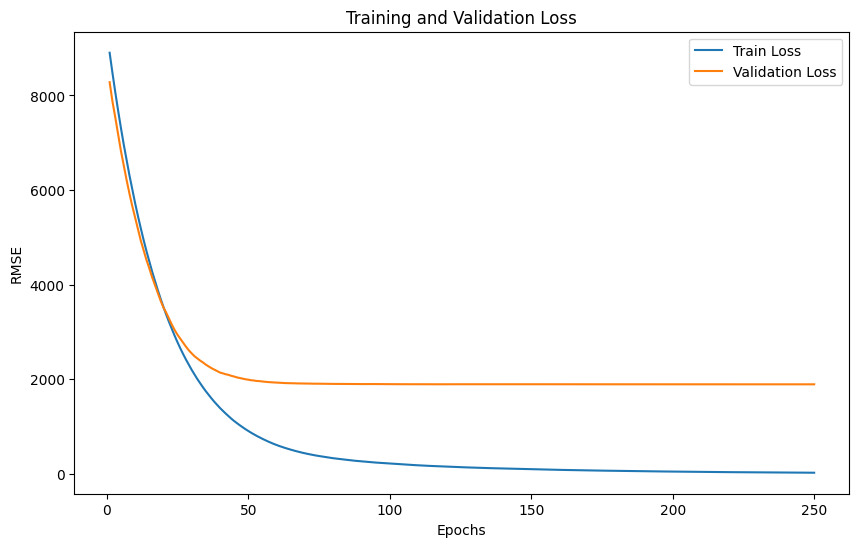

In [11]:
best_model = random_search.best_estimator_
val_preds = best_model.predict(X_test)
val_rmse = np.sqrt(mean_squared_error(Y_test, val_preds))
val_mae = mean_absolute_error(Y_test, val_preds)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('best params\n',random_search.best_params_)

best_model.fit(X_train, Y_train,
               eval_set=[(X_train, Y_train), (X_test, Y_test)],
               verbose=0)
eval_results = best_model.evals_result()
res = best_model.predict(X_test)
plot_eval_result_XGBOOST(eval_results)

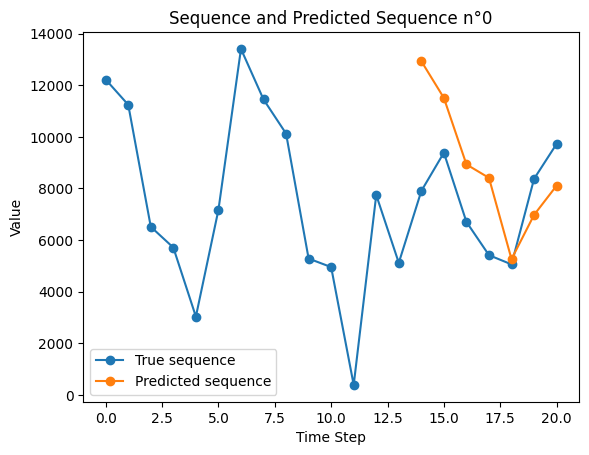

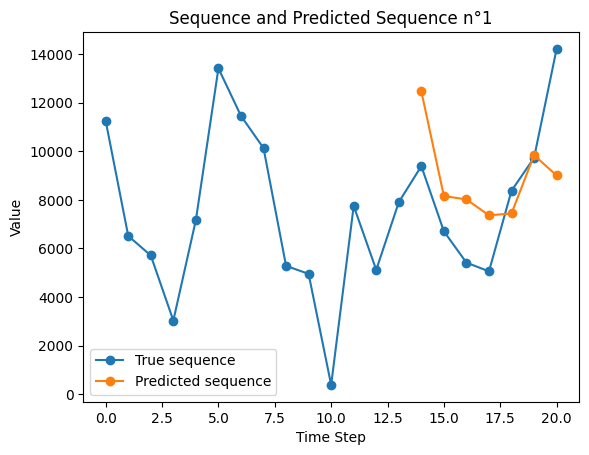

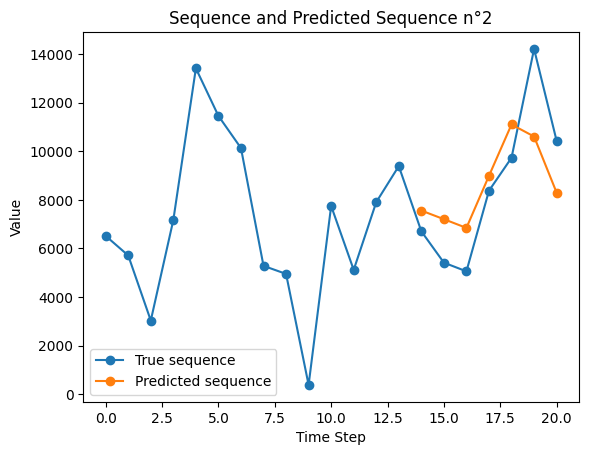

In [12]:
show_test(X_test,Y_test,res,input_sequence_length,output_sequence_length)

Best MAE validation: 2154.72216796875
Best RMSE validation: 2777.948974609375
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.07694825966991235, 'subsample': 0.749909284924509, 'colsample_bytree': 0.7783629948905457}


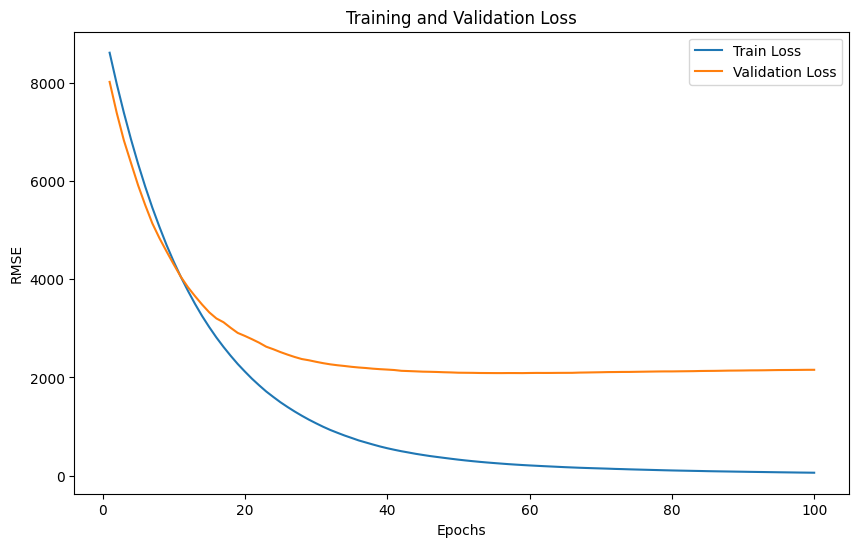

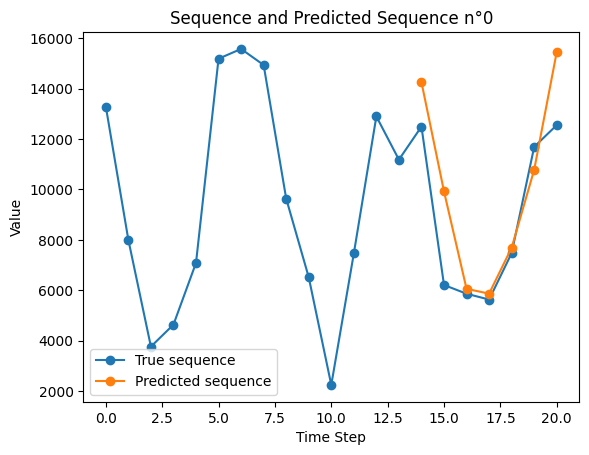

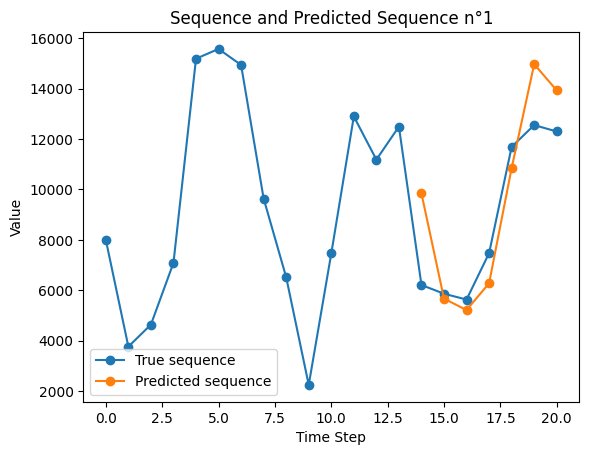

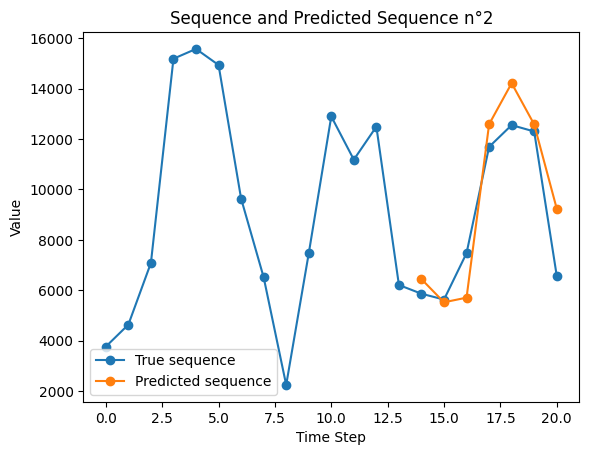

file saved at /Users/carlos/PycharmProjects/dionysos/prevision/results/Xgboost/saves/Xgboost_13.pkl


In [13]:
options = Options(model_type=XGBOOST_TYPE,input_sequence_length=input_sequence_length,
                      output_sequence_length=output_sequence_length,verbose_mod = 100, input_size=28)
a = Model(options)
b = DataLoader(options)
a.fineTuneXGBoostRay(b, None,100,scoring_Ray,eval_metric)

In [8]:
def feature_importance(best_model, X_train):
    """
    Calcule et affiche l'importance des fonctionnalités du modèle.

    Arguments:
    - best_model : meilleur modèle entraîné
    - X_train : données d'entraînement (features)
    """
    # Obtenir l'importance des fonctionnalités
    importance = best_model.feature_importances_
    print(len(importance))
    # Triez les fonctionnalités par importance décroissante
    feature_names = df_all.columns.tolist()
    print(feature_names)
    
    # Regrouper l'importance des day_0, day_1, day_2, day_3, day_4, day_5, day_6 en une seule colonne day
    day_0_index = feature_names.index('day_0')
    day_importance = np.sum(importance[day_0_index:day_0_index + 7])
    importance[day_0_index] = day_importance
    importance = np.delete(importance, range(day_0_index + 1, day_0_index + 7))
    feature_names = np.delete(feature_names, range(day_0_index + 1, day_0_index + 7))
    feature_names[day_0_index] = 'day'

    # Lister les fonctionnalités par importance décroissante
    feature_names = feature_names.tolist()
    feature_names = np.array(feature_names)
    indices = np.argsort(importance)[::-1]

    # Tracer le graphique de l'importance des fonctionnalités
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), importance[indices], tick_label=feature_names[indices].tolist())
    plt.xticks(rotation=90)
    plt.xlabel('Fonctionnalités')
    plt.ylabel('Importance')
    plt.title('Importance des fonctionnalités')
    plt.show()

feature_importance(best_model, X_train)

392
['vente', 'apparent_temperature_max', 'apparent_temperature_min', 'sunset', 'uv_index_max', 'rain_sum', 'showers_sum', 'snowfall_sum', 'precipitation_hours', 'attendance_concerts', 'attendance_conferences', 'attendance_expos', 'attendance_festivals', 'attendance_performing_arts', 'attendance_sports', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'vacance', 'ferie', 'match_mma', 'match_nba', 'match_nfl', 'match_nhl']


IndexError: index 228 is out of bounds for axis 0 with size 22

<Figure size 1000x600 with 0 Axes>